Convolutional Sparse Coding with Mask Decoupling (ADMM)
=======================================================

This example demonstrates the solution of a convolutional sparse coding
problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - B (\sum_k
  \mathbf{h}_k \ast \mathbf{x}_k) \|_2^2 + \lambda \sum_k
  \| \mathbf{x}_k \|_1  \;,$$

where the $\mathbf{h}$_k is a set of filters comprising the dictionary,
the $\mathbf{x}$_k is a corrresponding set of coefficient maps,
$\mathbf{y}$ is the signal to be represented, and $B$ is a cropping
operator that allows the boundary artifacts resulting from circular
convolution to be avoided. Following the mask decoupling approach
<cite data-cite="almeida-2013-deconvolving"/>, the problem is posed in ADMM form
as

  $$\mathrm{argmin}_{\mathbf{x}, \mathbf{z}_0, \mathbf{z}_1} \; (1/2) \|
  \mathbf{y} - B \mb{z}_0 \|_2^2 + \lambda \sum_k \| \mathbf{z}_{1,k}
  \|_1  \\ \;\; \text{s.t.} \;\; \mathbf{z}_0 = \sum_k \mathbf{h}_k \ast
  \mathbf{x}_k \;\; \mathbf{z}_{1,k} = \mathbf{x}_k\;,$$.

The most computationally expensive step in the ADMM algorithm is solved
using the frequency-domain approach proposed in
<cite data-cite="wohlberg-2014-efficient"/>.

In [1]:
import numpy as np

import jax

import scico.numpy as snp
from scico import plot
from scico.examples import create_conv_sparse_phantom
from scico.functional import DiffL1L2Norms, ZeroFunctional
from scico.linop import CircularConvolve, Identity, Sum, Crop
from scico.loss import SquaredL2Loss
from scico.optimize.admm import ADMM, BlockCircularConvolveForm2Solver
from scico.util import device_info
plot.config_notebook_plotting()

Set problem size and create random convolutional dictionary (a set of
filters) and a corresponding sparse random set of coefficient maps.

In [2]:
N = 121  # image size
Nnz = 128  # number of non-zeros in coefficient maps
h, x0 = create_conv_sparse_phantom(N, Nnz)

Normalize dictionary filters and scale coefficient maps accordingly.

In [3]:
hnorm = np.sqrt(np.sum(h**2, axis=(1, 2), keepdims=True))
h /= hnorm
x0 *= hnorm

Convert numpy arrays to jax arrays.

In [4]:
h = jax.device_put(h)
x0 = jax.device_put(x0)

Set up required padding and corresponding crop operator.

In [5]:
h_center = (h.shape[1] // 2, h.shape[2] // 2)
pad_width = ((0, 0), (h_center[0], h_center[0]), (h_center[1], h_center[1]))
x0p = snp.pad(x0, pad_width=pad_width)
B = Crop(pad_width[1:], input_shape=x0p.shape[1:])

Set up sum-of-convolutions forward operator.

In [6]:
C = CircularConvolve(h, input_shape=x0p.shape, ndims=2, h_center=h_center)
S = Sum(input_shape=C.output_shape, axis=0)
A = S @ C

Construct test image from dictionary $\mathbf{h}$ and coefficient maps
$\mathbf{x}_0$.

In [7]:
y = B(A(x0p))

Set functional and solver parameters.

In [8]:
λ = 1e0  # l1-l2 norm regularization parameter
ρ0 = 1e0  # ADMM penalty parameters
ρ1 = 3e0
maxiter = 200  # number of ADMM iterations

Define loss function and regularization. Note the use of the
:math:`\ell_1 - \ell_2` norm, which has been found to provide
slightly better performance than the :math:`\ell_1` norm in
this type of problem.

In [9]:
f = ZeroFunctional()
g0 = SquaredL2Loss(y=y, A=B)
g1 = λ * DiffL1L2Norms()
C0 = A
C1 = Identity(input_shape=x0p.shape)

Initialize ADMM solver.

In [10]:
solver = ADMM(
    f=f,
    g_list=[g0, g1],
    C_list=[C0, C1],
    rho_list=[ρ0, ρ1],
    alpha=1.8,
    maxiter=maxiter,
    subproblem_solver=BlockCircularConvolveForm2Solver(check_solve=True),
    itstat_options={"display": True, "period": 10},
)
#solver.z_list[0] = snp.pad(y, pad_width=pad_width[1:])

Run the solver.

In [11]:
print(f"Solving on {device_info()}\n")
x1 = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on CPU



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  Slv Res  
----------------------------------------------------------
   0  4.52e-01  1.836e+04  1.916e+02  2.736e+03  0.000e+00
  10  7.68e-01  3.178e+03  3.953e+00  3.332e+01  7.611e-06


  20  8.90e-01  2.910e+03  1.636e+00  1.482e+01  8.458e-06


  30  1.02e+00  2.813e+03  1.143e+00  1.363e+01  8.146e-06
  40  1.14e+00  2.747e+03  8.765e-01  5.998e+00  5.407e-06


  50  1.27e+00  2.707e+03  7.316e-01  7.191e+00  6.305e-06


  60  1.41e+00  2.676e+03  6.445e-01  7.266e+00  3.528e-06
  70  1.56e+00  2.649e+03  5.722e-01  3.833e+00  2.572e-06


  80  1.72e+00  2.627e+03  5.302e-01  3.220e+00  4.667e-06


  90  1.85e+00  2.608e+03  4.999e-01  4.045e+00  5.881e-06
 100  1.98e+00  2.589e+03  4.702e-01  3.141e+00  2.813e-06


 110  2.11e+00  2.574e+03  4.422e-01  1.753e+00  2.696e-06
 120  2.23e+00  2.559e+03  4.215e-01  2.060e+00  2.969e-06


 130  2.36e+00  2.546e+03  4.064e-01  2.171e+00  2.951e-06


 140  2.49e+00  2.533e+03  3.905e-01  1.379e+00  4.731e-06
 150  2.63e+00  2.521e+03  3.772e-01  1.115e+00  5.164e-06


 160  2.78e+00  2.510e+03  3.655e-01  1.384e+00  4.955e-06


 170  2.94e+00  2.500e+03  3.521e-01  1.146e+00  3.436e-06


 180  3.09e+00  2.490e+03  3.377e-01  8.521e-01  6.164e-06
 190  3.23e+00  2.481e+03  3.243e-01  8.949e-01  5.721e-06


 199  3.35e+00  2.474e+03  3.110e-01  8.899e-01  6.410e-06


Show the recovered coefficient maps.

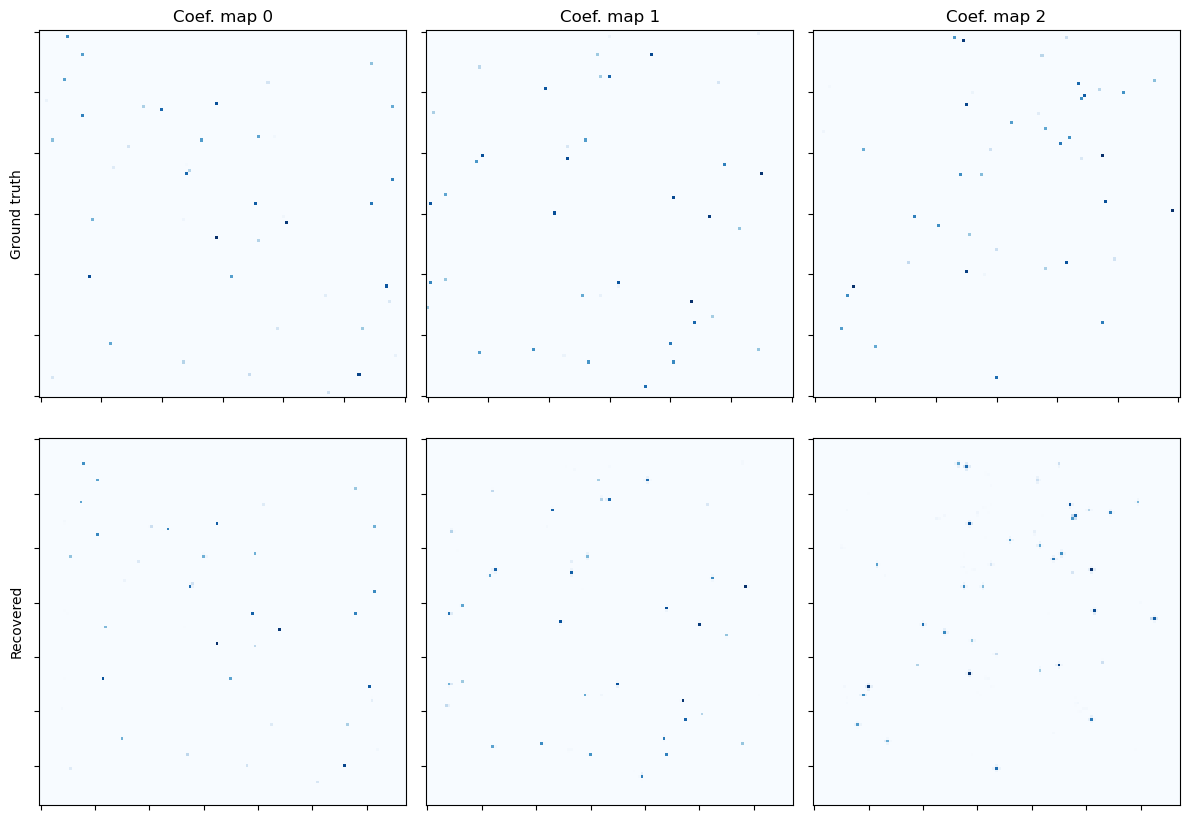

In [12]:
fig, ax = plot.subplots(nrows=2, ncols=3, figsize=(12, 8.6))
plot.imview(x0[0], title="Coef. map 0", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 0])
ax[0, 0].set_ylabel("Ground truth")
plot.imview(x0[1], title="Coef. map 1", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 1])
plot.imview(x0[2], title="Coef. map 2", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 2])
plot.imview(x1[0], cmap=plot.cm.Blues, fig=fig, ax=ax[1, 0])
ax[1, 0].set_ylabel("Recovered")
plot.imview(x1[1], cmap=plot.cm.Blues, fig=fig, ax=ax[1, 1])
plot.imview(x1[2], cmap=plot.cm.Blues, fig=fig, ax=ax[1, 2])
fig.tight_layout()
fig.show()

Show test image and reconstruction from recovered coefficient maps.

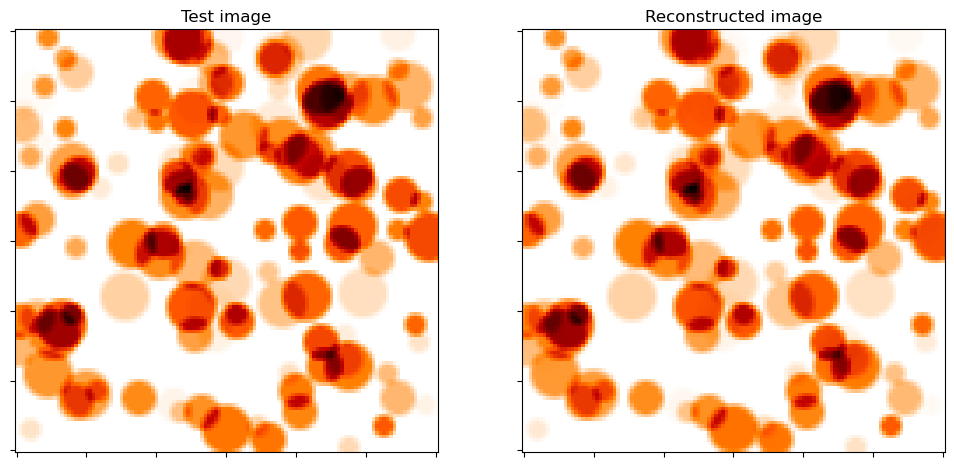

In [13]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 6))
plot.imview(y, title="Test image", cmap=plot.cm.gist_heat_r, fig=fig, ax=ax[0])
plot.imview(B(A(x1)), title="Reconstructed image", cmap=plot.cm.gist_heat_r, fig=fig, ax=ax[1])
fig.show()

Plot convergence statistics.

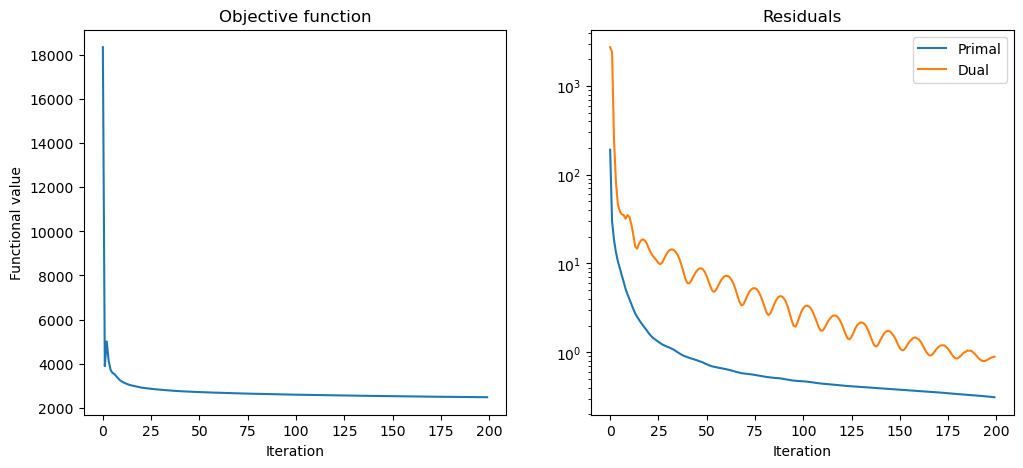

In [14]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()